# A

In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize
from transformer_architecture_elements import Time2Vector, SingleAttention, MultiAttention, TransformerEncoder

In [18]:
# filename = 'Benchmark/trained_models/LSTM_univariate2_classification____0150.hdf5'  # Classification model
# filename = 'Benchmark/trained_models/LSTM_univariate2_with_close_price____0150.hdf5'  # Regression model
filename = 'content/Transformer+TimeEmbedding2_minmax____0300.hdf5'

my_LSTM_model = tf.keras.models.load_model(
    filename,
    custom_objects={
        'kl_divergence': kullback_leibler_divergence,
        'Time2Vector': Time2Vector,
        'SingleAttention': SingleAttention,
        'MultiAttention': MultiAttention,
        'TransformerEncoder': TransformerEncoder
    }
)
lag = my_LSTM_model.input_shape[1]
print(f'lag: {lag}')
h = my_LSTM_model.output_shape[1]
print(f'h: {h}')

lag: 64
h: 1


In [19]:
my_LSTM_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 2)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 64, 2)        256         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 64, 4)        0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 64, 4)        16920       concatenate[0][0]            

In [20]:
def predictions(my_model, X_test, sc=None):
    LSTM_prediction = my_model.predict(X_test)
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction

In [22]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')

df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'EURUSD BGNE Curncy Bid Close'
target_column = list(df.columns).index(target)

df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
df = df.iloc[:, target_column : target_column + 1]

In [23]:
def strategy(x):
    conditions = [
        (x <= -0.00000001),
        (x > -0.00000001) & (x <= 0.00000001),
        (x > 0.00000001)
    ]

    # create a list of the values we want to assign for each condition #!!! 
    values = ['sell', 'hold', 'buy']
    values = [0, 1, 2]

    # create a new column and use np.select to assign values to it using our lists as arguments #!!! 
    return np.select(conditions, values).astype(np.int32)
df['strategy'] = strategy(df[target])

df.head()

,EURUSD BGNE Curncy Bid Close,strategy
Dates,,
2020-11-01 19:10:00,0.000000,1
2020-11-01 19:20:00,0.000275,2
2020-11-01 19:30:00,-0.000069,0
2020-11-01 19:40:00,0.000034,2
2020-11-01 19:50:00,0.000026,2


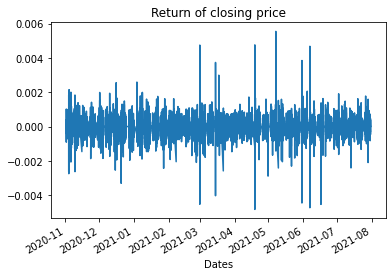

In [24]:
df[target].plot()
plt.title('Return of closing price')
plt.show()

In [25]:
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, 1)

In [26]:
X_train = X_train#.astype(dtype)
X_val = X_val#.astype(dtype)
X_test = X_test#.astype(dtype)
y_train = sc_target.inverse_transform(y_train)
y_val = sc_target.inverse_transform(y_val)
y_test = sc_target.inverse_transform(y_test)

## Econmetric measures

Definition of cumulated returns

In [27]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

In [29]:
#!!! for testing purposes
tmp_type = 'train'

X = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)
for i in range(lag):
    diff = np.abs(df.loc[eval(f"index_{tmp_type}")].iloc[i:-(lag - i + 1)].values - X[:,-(lag - i)]).sum(axis=0)
    assert diff[0] < 1e-6 and diff[1] < 0.5, 'df and X inversed are not the same'

X_ret_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 0]
y_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]

a = sc_target.inverse_transform(eval(f"y_{tmp_type}")).flatten()
b = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]
cc = df.loc[eval(f"index_{tmp_type}")].iloc[(lag - 1):-(h+1), 1].values
print(np.abs(cc[1:] - a[:-1]).sum(axis=0))
print(np.abs(cc - b).sum(axis=0))

23076.118750894686
0.0


In [31]:
print((index_train[0:-(lag+1)] == X_train_index[:, 0]).all())
print((index_train[(lag-1):-(h+1)] == X_train_index[:, -1]).all())

True
True


## read in data for econmic metric

In [32]:
def econ_metrics(y_pred, X_ret, risk_free=0):  # Risk free rate must be given
    x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)
    print(f'Portfolio return: {x[-1] / x[0] - 1}')
    print(f'Std of returns: {np.std(x[1:] / x[:-1])}')
    print(f'Sharpe ratio: {((x[-1] / x[0]) - 1 - risk_free) / np.std(x[1:] / x[:-1])}')
    print()

    n = 6 * 24 * 250  # banking days per year
    mu_annum = ((x[-1]/x[0]) ** (1 / x.shape[0])) ** n - 1
    print(f'Return per annum: {mu_annum}')
    std_annum = np.std(x[1:] / x[:-1]) * (n)**0.5
    print(f'Std of returns per annum: {std_annum}')
    print(f'Sharpe ratio per annum: {(mu_annum - risk_free) / std_annum}')

In [35]:
def result_output2(tmp_type):
    print(tmp_type)

    y = eval(f"y_{tmp_type}")
    if my_LSTM_model.layers[-1].activation == tf.keras.activations.softmax:
        y_pred = np.argmax(predictions(
            my_LSTM_model,
            eval(f"X_{tmp_type}")
        ), axis=1)
    else:
        y_pred = strategy(predictions(
            my_LSTM_model,
            eval(f"X_{tmp_type}")
        ))
    print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
    print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
    print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

    X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
    plt.plot(eval(f"index_{tmp_type}")[lag-1:-(h+1)][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

    p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
    x = np.concatenate(
        [
            cumulated_return(
                np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
                X_ret[1:],
                dtype=dtype
            )[:,np.newaxis] for i in range(50)
        ], axis=-1
    )
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1), label='random', color='gray')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
    plt.legend()
    plt.semilogy()
    plt.show()
    econ_metrics(y_pred, X_ret)

train
Accuracy: 0.47764095664024353
Accuracy: 0.47094404697418213
KL_Divergence: 58218.546875
              precision    recall  f1-score   support

         0.0       0.46      0.29      0.35     10900
         1.0       0.00      0.00      0.00       926
         2.0       0.48      0.70      0.57     11319

    accuracy                           0.48     23145
   macro avg       0.32      0.33      0.31     23145
weighted avg       0.45      0.48      0.45     23145



/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


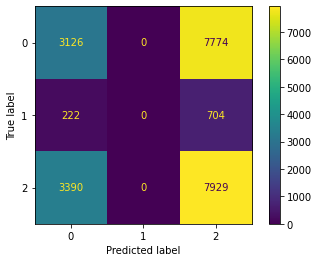

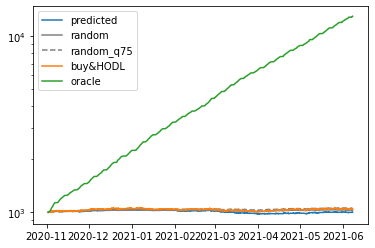

Portfolio return: 0.002037525177001953
Std of returns: 0.00027962360763922334
Sharpe ratio: 7.286670800810259

Return per annum: 0.0031711200856048283
Std of returns per annum: 0.05305484926159224
Sharpe ratio per annum: 0.059770598347557324


In [36]:
result_output2('train')

val
Accuracy: 0.46212121844291687
Accuracy: 0.4942280054092407
KL_Divergence: 11476.0830078125
              precision    recall  f1-score   support

         0.0       0.47      0.46      0.46      1370
         1.0       0.31      0.11      0.16        82
         2.0       0.46      0.49      0.47      1320

    accuracy                           0.46      2772
   macro avg       0.41      0.35      0.37      2772
weighted avg       0.46      0.46      0.46      2772



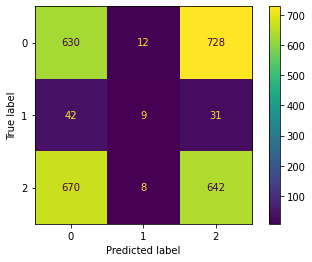

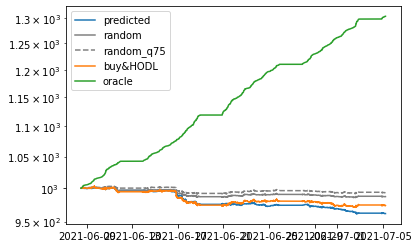

Portfolio return: -0.03826063871383667
Std of returns: 0.00021819723770022392
Sharpe ratio: -175.34886837752762

Return per annum: -0.3975975782441108
Std of returns per annum: 0.041400015017392065
Sharpe ratio per annum: -9.603802754107235


In [16]:
result_output('val')

test
Accuracy: 0.48593074083328247
Accuracy: 0.47330448031425476
KL_Divergence: 11121.484375
              precision    recall  f1-score   support

         0.0       0.48      0.48      0.48      1312
         1.0       0.09      0.05      0.07        75
         2.0       0.50      0.51      0.51      1385

    accuracy                           0.49      2772
   macro avg       0.36      0.35      0.35      2772
weighted avg       0.48      0.49      0.48      2772



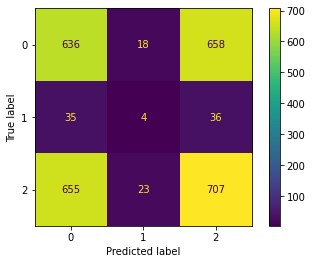

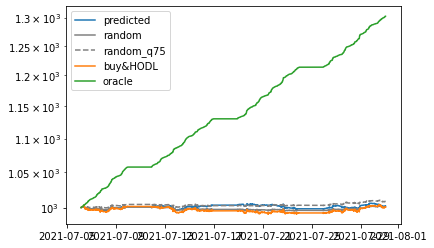

Portfolio return: 0.0020194053649902344
Std of returns: 0.00020833703456446528
Sharpe ratio: 9.692973547462941

Return per annum: 0.02655553129066468
Std of returns per annum: 0.03952917301133616
Sharpe ratio per annum: 0.6717957717721313


In [17]:
result_output('test')